# HW3P2: Speech Recognition with Neural Networks: Utterance to Phoneme Mapping


# Schedule:
- Checkpoint Submission (DUE 31 October 2025 @ 11:59PM EST)
- Final Submission (DUE 7 November 2025 @ 11:59PM EST | Slack Deadline 14 November 2025 @ 11:59PM EST)
- Code Submission (DUE 9 November 2025 @ 11:59PM EST OR Day-of Slack submission)

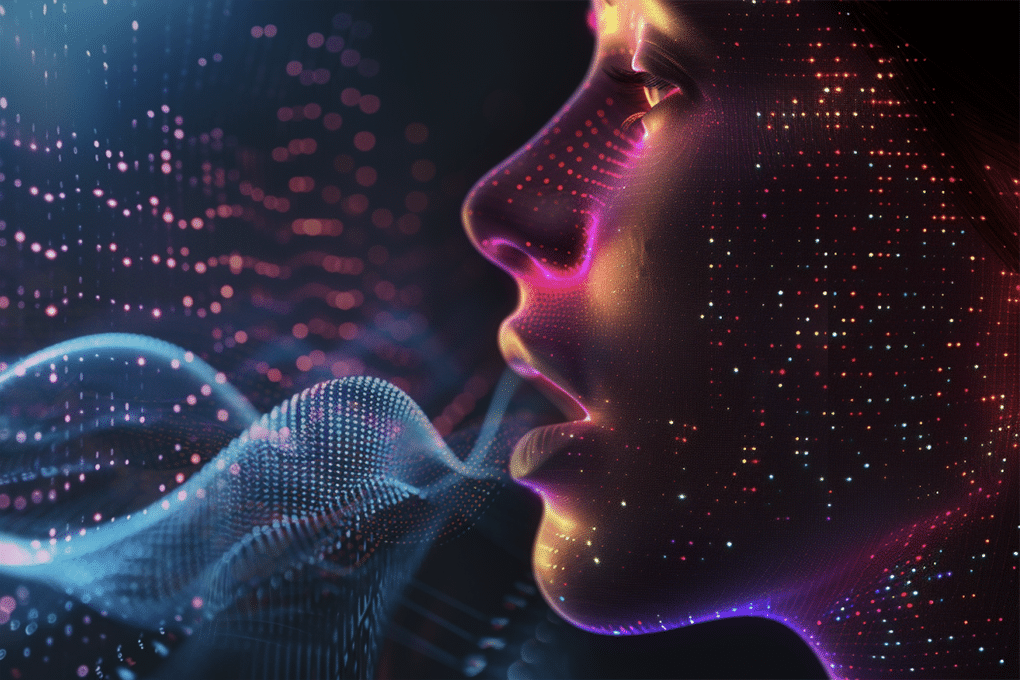

## Requirement Acknowledgement
Setting the below flag to True indicates full understanding and acceptance of the following:
1. Slack days may ONLY be used on P2 FINAL (not checkpoint) submission. I.e. you may use slack days to submit final P2 kaggle scores (such as this one) later on the **SLACK KAGGLE COMPETITION** at the expense of your Slack days.
2. The final autolab **code submission is due 48 hours after** the conclusion of the Kaggle Deadline (or, the same day as your final Kaggle submission).
3. We will require your kaggle username here, and then we will pull your official PRIVATE kaggle leaderboard score. This submission may result in slight variance in scores/code, but we will check for acceptable discrepancies. Any discrepancies related to modifying the submission code (at the bottom of the notebook) will result in an AIV.
4. You are NOT allowed to use any code that will pre-load models (such as those from Hugging Face, etc.).
   You MAY use models described by papers or articles, but you MUST implement them yourself through fundamental PyTorch operations (i.e. Linear, Conv2d, etc.).
5. You are NOT allowed to use any external data/datasets at ANY point of this assignment.
6. You may work with teammates to run ablations/experiments, BUT you must submit your OWN code and your OWN results.
7. Failure to comply with the prior rules will be considered an Academic Integrity Violation (AIV).
8. Late submissions MUST be submitted through the Slack Kaggle (see writeup for details). Any submissions made to the regular Kaggle after the original deadline will NOT be considered, no matter how many slack days remain for the student.

In [61]:
ACKNOWLEDGED = True #TODO: Only set Acknowledged to True if you have read the above acknowlegements and agree to ALL of them.

In this assignment, you'll build a sequence-to-sequence model that maps speech utterances to phoneme sequences. You'll implement a recurrent neural network architecture that processes speech feature vectors (MFCCs) and outputs corresponding phoneme sequences.

## Key Components

- **Data Processing**: Work with Mel-Frequency Cepstral Coefficients (MFCCs) and handle variable-length sequences through padding and packing
- **Neural Network Architecture**: Implement a model using basic CNNs for feature extraction, BiLSTMs for sequential modeling, and optional pyramidal BiLSTMs for downsampling
- **CTC Loss**: Train your model using Connectionist Temporal Classification to handle sequence alignment challenges
- **Decoding Strategies**: Explore both greedy search and beam search for phoneme sequence generation
- **Evaluation**: Use Levenshtein Distance to measure the accuracy of your predicted phoneme sequences
- **Submission**: Submit your results on kaggle for final evaluation.

This assignment will give you practical experience with sequence modeling techniques essential to speech recognition systems while exploring various architectural choices and optimization strategies.

# **SET-UP**

Firstly, join the kaggle competition. (https://www.kaggle.com/t/2a94d2c1488a4798b02012f37682d5d8)

## **Google Colab Users**

### Step 1. Environment Setup

In [ ]:
# Run this to see what GPU you have
!nvidia-smi

Thu Oct  9 22:16:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Uncomment this if you want to use Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Install the packages needed
!pip install torchinfo --quiet
!pip install python-Levenshtein --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 75.6 MB/s eta 0:00:00


In [2]:
import torch
import random
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import wandb
import torchaudio.transforms as tat
from torchaudio.models.decoder import cuda_ctc_decoder
import Levenshtein

from sklearn.metrics import accuracy_score
import gc

import glob

import zipfile
from tqdm.auto import tqdm
import os
import datetime


import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


/home/agcheria/miniconda3/envs/IDL_F25/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 2. Kaggle API Setup

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.7.4.2
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:

    f.write('{"username":"____________","key":"_________________________"}') # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5


### Step 3. Download Data (Chill out it will take a while😀)

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

# Download Data from Kaggle. If an error occurs, try to download the data directly from the browser. Go to "data" section in the competition page, and click on "Download All".
!kaggle competitions download -c 11785-hw-3-p-2-speech-recognition-fall-2025
!unzip -q 11785-hw-3-p-2-speech-recognition-fall-2025.zip # Unzip the dataset

  Using cached kaggle-1.7.4.5-py3-none-any.whl.metadata (16 kB)
Using cached kaggle-1.7.4.5-py3-none-any.whl (181 kB)
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.2
    Uninstalling kaggle-1.7.4.2:
      Successfully uninstalled kaggle-1.7.4.2
401 Client Error: Unauthorized for url: https://www.kaggle.com/api/v1/competitions/data/download-all/11785-hw-3-p-2-speech-recognition-fall-2025
unzip:  cannot find or open 11785-hw-3-p-2-speech-recognition-fall-2025.zip, 11785-hw-3-p-2-speech-recognition-fall-2025.zip.zip or 11785-hw-3-p-2-speech-recognition-fall-2025.zip.ZIP.


## **Kaggle Users**

### Step 1. Environment Setup

In [ ]:
# Install the packages needed
!pip install torchinfo --quiet
!pip install python-Levenshtein --quiet

In [ ]:
import torch
import random
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import wandb
import torchaudio.transforms as tat
from torchaudio.models.decoder import cuda_ctc_decoder
import Levenshtein

from sklearn.metrics import accuracy_score
import gc

import glob

import zipfile
from tqdm.auto import tqdm
import os
import datetime


import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


### Step 2. Download Data

If you are using Kaggle, follow these steps to add the dataset directly to your notebook:
1. Join the kaggle competition (https://www.kaggle.com/t/2a94d2c1488a4798b02012f37682d5d8)
2. Open your **Kaggle Notebook**.  
3. Navigate to **Notebook → Input**.  
4. Click **Add Input**.  
5. Choose "Competition Datasets" and "Your work", and then you'll be able to see the competiation "11785-hw-3-p-2-speech-recognition-fall-2025"
6. Click the **➕ (plus sign)** to add the dataset to your notebook.

## **PSC Users**

### 1️⃣ **Step 1: Set Up the Environment on Bridges2**

❗️⚠️ For this homework, we are **providing shared Datasets and a shared Conda environment** for the entire class.

❗️⚠️ So for PSC users, **do not download the data yourself** and **do not need to manually install the packages**!

Follow these steps to set up the environment and start a Jupyter notebook on Bridges2:

To run your notebook more efficiently on PSC, we need to use a **Jupyter Server** hosted on a compute node.

You can use your prefered way of connecting to the Jupyter Server. **The recommended way is to connect in VSCode.**

Follow the instructions below.

#### **1.1 SSH into Bridges2**
1）Open VS Code and click on the `Extensions` icon in the left sidebar. Make sure the "**Remote - SSH**" extension is installed.

2）Open the command palette (**Shift+Command+P** on Mac, **Ctrl+Shift+P** on Windows). A search box will appear at the top center. Choose `"Remote-SSH: Add New SSH Host"`, then enter:

```bash
ssh <your_username>@bridges2.psc.edu #change <your_username> to your username
```

Next, choose `"/Users/<your_username>/.ssh/config"` as the config file. A dialog will appear in the bottom right saying "Host Added". Click `"Connect"`, and then enter your password.

(Note: After adding the host once, you can later use `"Remote-SSH: Connect to Host"` and select "bridges2.psc.edu" from the list.)

3）Once connected, click `"Explorer"` in the left sidebar > "Open Folder", and navigate to your home directory under the project grant:
```bash
/jet/home/<your_username>  #change <your_username> to your username
```

4）You can now drag your notebook files directly into the right-hand pane (your remote home directory), or upload them using `scp` into your folder.

> ❗️⚠️ The following steps should be executed in the **VSCode integrated terminal**.

#### **1.2 Navigate to Your Directory**
Make sure to use this `/jet/home/<your_username>` as your working directory, since all subsequent operations (up to submission) are based on this path.
```bash
cd /jet/home/<your_username>  #change <your_username> to your username
```

#### **1.3 Request a Compute Node**
```bash
interact -p GPU-shared --gres=gpu:v100-32:1 -t 8:00:00 -A cis250019p
```

#### **1.4 Load the Anaconda Module**
```bash
module load anaconda3
```

#### **1.5 Activate the provided HW3 Environment**
```bash
conda deactivate # First, deactivate any existing Conda environment
conda activate /ocean/projects/cis250019p/mzhang23/TA/HW3P2/envs/hw3p2_env && export PYTHONNOUSERSITE=1
```

##### Optional:
If you prefer, you can export the kernel manually using the command below.
This will register your HW3 environment (hw3p2_env) in the Jupyter, so you can directly select it in the notebook’s top-right corner via `Select Kernel → Jupyter Kernel → idl_hw3p2`. In that case, you don’t need to run Step 1.6 (--no-browser launch).
```bash
python -m ipykernel install --user --name hw3p2_env --display-name "Python (idl_hw3p2)"
```

#### **1.6 Start Jupyter Notebook**
Before launching Jupyter Notebook, make sure you activate your virtual environment (Step 1.5) in the same terminal where you will run the `--no-browser` command. Otherwise, the kernel associated with that environment will not appear in Jupyter.

Launch Jupyter Notebook:
```bash
jupyter notebook --no-browser --ip=0.0.0.0
```

Go to **Kernel** → **Select Another Kernel** → **Existing Jupyter Server** (select the idl_hw3p2 virtual environment to use)
  
Enter the URL of the Jupyter Server:```http://{hostname}:{port}/tree?token={token}```
   
   *(Usually, this URL appears in the terminal output after you run `jupyter notebook --no-browser --ip=0.0.0.0`, in a line like:  “Jupyter Server is running at: http://...”)*

   - eg: `http://v011.ib.bridges2.psc.edu:8888/tree?token=e4b302434e68990f28bc2b4ae8d216eb87eecb7090526249`  (change accordingly)


> **Note**: Replace `{hostname}`, `{port}` and `{token}` with your actual values from the Jupyter output.

#### **1.7 Import dependencies**

After launching the Jupyter notebook, you can run the cells directly inside the notebook — no need to use the terminal for the remaining steps.

First, import the dependencies.  
(*If you followed the previous steps and correctly activated our shared `hw3p2` environment, you do **not** need to install anything manually.*)

In [ ]:
#Make sure you are in your directory
!pwd #should be /jet/home/<your_username>, if not, uncomment the following line and replace with your actual username
%cd /jet/home/<your_username>  #TODO: replace the "<your_username>" to yours

In [ ]:
import torch
import random
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import wandb
import torchaudio.transforms as tat
from torchaudio.models.decoder import cuda_ctc_decoder
import Levenshtein

from sklearn.metrics import accuracy_score
import gc

import glob

import zipfile
from tqdm.auto import tqdm
import os
import datetime


import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

### 2️⃣ **Step 2: Set up Kaggle API Authentication**

In [ ]:
# TODO: Use the same Kaggle code from HW3P2
!mkdir /jet/home/<your_username>/.kaggle #TODO: replace the "<your_username>" to yours

with open("/jet/home/<your_username>/.kaggle/kaggle.json", "w+") as f: #TODO: replace the "<your_username>" to yours
    f.write('{"username":"<your_username>","key":"<your_key>"}')
    # TODO: Put your kaggle username & key here

!chmod 600 /jet/home/<your_username>/.kaggle/kaggle.json #TODO: replace the "<your_username>" to yours

### 3️⃣ **Step 3: Download Data**

❗️⚠️ The data used in this assignment is **already stored in a shared, read-only folder, so you do not need to manually download anything**.

Instead, just make sure to replace the dataset path in your notebook code with the correct path from the shared directory.

You can run the following block to explore the shared directory structure:

In [ ]:
import os
data_path = "/ocean/projects/cis250019p/mzhang23/TA/HW3P2/hw3p2_data/11785-hw3p2" #Shared data path, do not need to change the username to yours
print("Files in shared hw3p2 dataset:", os.listdir(data_path))

In [ ]:
!apt-get install tree
!tree -L 2 /ocean/projects/cis250019p/mzhang23/TA/HW3P2/hw3p2_data/11785-hw3p2

# Config

In [ ]:
%%writefile config.yaml
# Subset of dataset to use (1.0 == 100% of data) = when you want to test if your notebook is running, you can use a subset of data
subset: 1.0
learning_rate: 0.001  # Slightly lower LR for fine-tuning from checkpoint - helps stability
epochs: 250  # Train longer for better convergence
train_beam_width: 6   # Max allowed
test_beam_width: 6    # Max allowed - must improve model itself
mfcc_features: 28 # DO NOT MODIFY
input_size: 28
kernel_size: 15  # Kernel size for Conv1d embedding (from successful notebook)
# Set embedding size (the dimensionality of the LSTM hidden state)
embed_size: 256   # Reduced from 256 to save parameters while staying under 20M

# Data directories
mfcc_train_dir: "/home/agcheria/idl_assignment_Fall_2025/HW3/HW3P2/11785-hw3p2/train-clean-100/mfcc"
mfcc_val_dir: "/home/agcheria/idl_assignment_Fall_2025/HW3/HW3P2/11785-hw3p2/dev-clean/mfcc"
mfcc_test_dir: "/home/agcheria/idl_assignment_Fall_2025/HW3/HW3P2/11785-hw3p2/test-clean/mfcc"
transcript_train_dir: "/home/agcheria/idl_assignment_Fall_2025/HW3/HW3P2/11785-hw3p2/train-clean-100/transcript"
transcript_val_dir: "/home/agcheria/idl_assignment_Fall_2025/HW3/HW3P2/11785-hw3p2/dev-clean/transcript"
fraction: 1.0  # Fraction of dataset to use

batch_size: 96 # Balanced between 64 and 128

encoder dropout: 0.2  # Back to proven value
lstm dropout: 0.2     # Back to proven value  
decoder dropout: 0.25  # Slightly higher in decoder
wandb: True # Set to True if you want to use WanDB

# Progressive Augmentation Curriculum
# Phase 1: Start with light augmentation (10, 10)
# Phase 2: After loading checkpoint, increase to (20, 20) or (30, 30)
freq_mask_param: 30  # Your proven best
time_mask_param: 30  # Your proven best

Name: "Abiencherian" # Write your name here
RUN_NAME: "EfficientNet based embedding-circiculum"

Writing config.yaml


In [4]:
import yaml
with open("config.yaml") as file:
    config = yaml.safe_load(file)

In [5]:
config

{'subset': 1.0,
 'learning_rate': '1e-4',
 'epochs': 250,
 'train_beam_width': 6,
 'test_beam_width': 6,
 'mfcc_features': 28,
 'input_size': 28,
 'kernel_size': 15,
 'embed_size': 256,
 'mfcc_train_dir': '/home/agcheria/idl_assignment_Fall_2025/HW3/HW3P2/11785-hw3p2/train-clean-100/mfcc',
 'mfcc_val_dir': '/home/agcheria/idl_assignment_Fall_2025/HW3/HW3P2/11785-hw3p2/dev-clean/mfcc',
 'mfcc_test_dir': '/home/agcheria/idl_assignment_Fall_2025/HW3/HW3P2/11785-hw3p2/test-clean/mfcc',
 'transcript_train_dir': '/home/agcheria/idl_assignment_Fall_2025/HW3/HW3P2/11785-hw3p2/train-clean-100/transcript',
 'transcript_val_dir': '/home/agcheria/idl_assignment_Fall_2025/HW3/HW3P2/11785-hw3p2/dev-clean/transcript',
 'fraction': 1.0,
 'batch_size': 96,
 'encoder dropout': 0.2,
 'lstm dropout': 0.2,
 'decoder dropout': 0.25,
 'wandb': True,
 'freq_mask_param': 30,
 'time_mask_param': 30,
 'Name': 'Abiencherian',
 'RUN_NAME': 'EfficientNet based embedding-circiculum'}

- You will need to set the root path to your `hw3p2_data` folder. This will depend on your setup. e.g.,
  - `Colab:`: `"/content/11785-hw3p2"`
  - `Kaggle:`: `"/kaggle/input/11785-hw-3-p-2-speech-recognition-fall-2025/11785-hw3p2"`
  - `PSC`: `"/ocean/projects/cis250019p/mzhang23/TA/HW3P2/hw3p2_data/11785-hw3p2"`

In [9]:
BATCH_SIZE = config["batch_size"] # Define batch size from config
root = "/home/agcheria/idl_assignment_Fall_2025/HW3/HW3P2/11785-hw3p2" # Specify the directory to your root based on your environment: Google Colab, Kaggle, or PSC

# Setup Vocabulary (DO NOT MODIFY)

In [10]:
# ARPABET PHONEME MAPPING
# DO NOT CHANGE

CMUdict_ARPAbet = {
    "" : " ",
    "[SIL]": "-", "NG": "G", "F" : "f", "M" : "m", "AE": "@",
    "R"    : "r", "UW": "u", "N" : "n", "IY": "i", "AW": "W",
    "V"    : "v", "UH": "U", "OW": "o", "AA": "a", "ER": "R",
    "HH"   : "h", "Z" :
     "z", "K" : "k", "CH": "C", "W" : "w",
    "EY"   : "e", "ZH": "Z", "T" : "t", "EH": "E", "Y" : "y",
    "AH"   : "A", "B" : "b", "P" : "p", "TH": "T", "DH": "D",
    "AO"   : "c", "G" : "g", "L" : "l", "JH": "j", "OY": "O",
    "SH"   : "S", "D" : "d", "AY": "Y", "S" : "s", "IH": "I",
    "[SOS]": "[SOS]", "[EOS]": "[EOS]"
}


CMUdict = list(CMUdict_ARPAbet.keys())
ARPAbet = list(CMUdict_ARPAbet.values())

PHONEMES = CMUdict[:-2] #To be used for mapping original transcripts to integer indices
LABELS = ARPAbet[:-2] #To be used for mapping predictions to strings

OUT_SIZE = len(PHONEMES) # Number of output classes
print("Number of Phonemes:", OUT_SIZE)

# Indexes of BLANK and SIL phonemes
BLANK_IDX=CMUdict.index('')
SIL_IDX=CMUdict.index('[SIL]')

print("Index of Blank:", BLANK_IDX)
print("Index of [SIL]:", SIL_IDX)

Number of Phonemes: 41
Index of Blank: 0
Index of [SIL]: 1


### Sample data inspection & sanity check

In [11]:
test_mfcc = f"{root}/train-clean-100/mfcc/103-1240-0000.npy"
test_transcript = f"{root}/train-clean-100/transcript/103-1240-0000.npy"

mfcc = np.load(test_mfcc)
transcript = np.load(test_transcript)[1:-1] #Removed [SOS] and [EOS]

print("MFCC Shape:", mfcc.shape)
print("\nMFCC:\n", mfcc)
print("\nTranscript shape:", transcript.shape)

print("\nOriginal Transcript:\n", transcript)

# map the loaded transcript (from phonemes representation) to corresponding labels representation
mapped_transcript = [CMUdict_ARPAbet[k] for k in transcript]
print("\nTranscript mapped from PHONEMES representation to LABELS representation:\n", mapped_transcript)

# Mapping list of PHONEMES to list of Integer indexes
map = {k: i for i, k in enumerate(PHONEMES)}
print("\nMapping list of PHONEMES to list of Integer indexes:\n", map)

MFCC Shape: (1404, 28)

MFCC:
 [[ 1.10582151e+01  1.28330450e+01  2.10689220e+01 ... -8.75406042e-02
   7.30623007e-02  9.48924713e+01]
 [ 1.16850815e+01  1.38329487e+01  2.19087906e+01 ... -1.39180899e-01
  -6.15991093e-02  9.55670319e+01]
 [ 1.11048431e+01  1.67276516e+01  2.28863831e+01 ... -4.03698802e-01
   8.09250996e-02  9.54314651e+01]
 ...
 [ 2.62413955e+00 -1.26996317e+01  2.79472313e+01 ... -1.49060452e+00
  -2.67574161e-01  1.16191261e+02]
 [ 3.05713993e-02 -1.20763254e+01  2.60116520e+01 ... -8.54688883e-01
  -1.20284989e-01  1.17127373e+02]
 [-1.33604801e+00 -1.17101593e+01  2.44703121e+01 ... -9.30283189e-01
  -8.16672146e-02  1.18280014e+02]]

Transcript shape: (145,)

Original Transcript:
 ['[SIL]' 'CH' 'AE' 'P' 'T' 'ER' 'W' 'AH' 'N' '[SIL]' 'M' 'IH' 'S' 'IH' 'Z'
 'R' 'EY' 'CH' 'AH' 'L' 'IH' 'N' 'D' 'IH' 'Z' 'S' 'ER' 'P' 'R' 'AY' 'Z'
 'D' '[SIL]' 'M' 'IH' 'S' 'IH' 'Z' 'R' 'EY' 'CH' 'AH' 'L' 'IH' 'N' 'D'
 '[SIL]' 'L' 'AY' 'V' 'D' '[SIL]' 'JH' 'AH' 'S' 'T' 'W' 'EH' 'R' '

# Dataset and Dataloader

### Train Data

In [12]:
class AudioDataset(torch.utils.data.Dataset):

    # For this homework, we give you full flexibility to design your data set class.
    # Hint: The data from HW1 is very similar to this HW

    #TODO
    def __init__(self,
                 PHONEMES,
                 mfcc_dir,
                 transcript_dir,
                 freq_mask_param,
                 time_mask_param,
                 fraction= 1,):
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        # Load the directory and all files in them
        self.time_mask = tat.TimeMasking(time_mask_param= time_mask_param, iid_masks=True)
        self.freq_mask = tat.FrequencyMasking(freq_mask_param= freq_mask_param, iid_masks=True)

        self.mfcc_dir = mfcc_dir
        self.transcript_dir = transcript_dir

        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))
        self.transcript_files = sorted(os.listdir(self.transcript_dir))

        self.phonemes = PHONEMES
        self.fraction = fraction

        #TODO
        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        self.length = len(self.mfcc_files)

        #TODO
        # HOW CAN WE REPRESENT PHONEMES? CAN WE CREATE A MAPPING FOR THEM?
        # HINT: TENSORS CANNOT STORE NON-NUMERICAL VALUES OR STRINGS
        self.phoneme_map = {p: i for i, p in enumerate(self.phonemes)}

        #TODO
        # CREATE AN ARRAY OF ALL FEATUERS AND LABELS
        # WHAT NORMALIZATION TECHNIQUE DID YOU USE IN HW1? CAN WE USE IT HERE?
        self.mfccs, self.transcripts = [], []

        for i, (mfcc_file, transcript_file) in enumerate(zip(self.mfcc_files, self.transcript_files)):
            if i == int(self.length * fraction):
                break
            mfcc = np.load(os.path.join(self.mfcc_dir, mfcc_file))
            transcript = np.load(os.path.join(self.transcript_dir, transcript_file))[1:-1]

            mean_mfcc   = np.mean(mfcc, axis = 0)
            std_mfcc = np.std(mfcc, axis = 0) + 1e-8
            mfcc  = (mfcc - mean_mfcc) / std_mfcc

            self.mfccs.append(mfcc)
            self.transcripts.append(transcript)
        '''
        You may decide to do this in __getitem__ if you wish.
        However, doing this here will make the __init__ function take the load of
        loading the data, and shift it away from training.
        '''


    def __len__(self):

        '''
        TODO: What do we return here?
        '''
        return int(self.length * self.fraction)

    def __getitem__(self, ind):
        '''
        TODO: RETURN THE MFCC COEFFICIENTS AND ITS CORRESPONDING LABELS

        If you didn't do the loading and processing of the data in __init__,
        do that here.

        Once done, return a tuple of features and labels.
        '''

        # raise NotImplemented

        mfcc =  self.mfccs[ind]# TODO
        transcript = self.transcripts[ind]# TODO
        mapped_transcript = np.vectorize(lambda x: self.phoneme_map[x])(transcript)
        return torch.FloatTensor(mfcc), torch.tensor(mapped_transcript)


    def collate_fn(self,batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features,
            and lengths of labels.
        '''
        batch_mfcc, batch_transcript = zip(*batch)

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True) # TODO
        lengths_mfcc = torch.tensor([mfcc.shape[0] for mfcc in batch_mfcc]) # TODO

        batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True) # TODO
        lengths_transcript = torch.tensor([transcript.shape[0] for transcript in batch_transcript]) # TODO

        # You may apply some transformation, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?
        # batch_mfcc_pad.transpose(1, 2)
        # batch_mfcc_pad = self.time_mask(batch_mfcc_pad)
        # batch_mfcc_pad = self.freq_mask(batch_mfcc_pad)
        # batch_mfcc_pad.transpose(1, 2)

        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

### Test Data

In [13]:
class AudioDatasetTest(torch.utils.data.Dataset):

    # For this homework, we give you full flexibility to design your data set class.
    # Hint: The data from HW1 is very similar to this HW

    #TODO
    def __init__(self,
                 PHONEMES,
                 mfcc_dir,
                 fraction= 1):
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        # Load the directory and all files in them

        self.mfcc_dir = mfcc_dir

        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))

        self.phonemes = PHONEMES

        #TODO
        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        self.length = len(self.mfcc_files)
        self.fraction = fraction

        #TODO
        # HOW CAN WE REPRESENT PHONEMES? CAN WE CREATE A MAPPING FOR THEM?
        # HINT: TENSORS CANNOT STORE NON-NUMERICAL VALUES OR STRINGS
        self.phoneme_map = {p: i for i, p in enumerate(self.phonemes)}

        #TODO
        # CREATE AN ARRAY OF ALL FEATUERS AND LABELS
        # WHAT NORMALIZATION TECHNIQUE DID YOU USE IN HW1? CAN WE USE IT HERE?
        self.mfccs = []

        for i, mfcc_file in enumerate(self.mfcc_files):
            if i == int(self.length * fraction):
                break
            mfcc = np.load(os.path.join(self.mfcc_dir, mfcc_file))

            mean_mfcc   = np.mean(mfcc, axis = 0)
            std_mfcc = np.std(mfcc, axis = 0) + 1e-8
            mfcc  = (mfcc - mean_mfcc) / std_mfcc

            self.mfccs.append(mfcc)
        '''
        You may decide to do this in __getitem__ if you wish.
        However, doing this here will make the __init__ function take the load of
        loading the data, and shift it away from training.
        '''


    def __len__(self):

        '''
        TODO: What do we return here?
        '''
        return int(self.length * self.fraction)

    def __getitem__(self, ind):
        '''
        TODO: RETURN THE MFCC COEFFICIENTS AND ITS CORRESPONDING LABELS

        If you didn't do the loading and processing of the data in __init__,
        do that here.

        Once done, return a tuple of features and labels.
        '''

        # raise NotImplemented

        mfcc =  self.mfccs[ind]# TODO
        return torch.FloatTensor(mfcc)



    def collate_fn(self,batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features,
            and lengths of labels.
        '''
        batch_mfcc= [mfcc for mfcc in batch]

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True) # TODO
        lengths_mfcc = torch.tensor([mfcc.shape[0] for mfcc in batch_mfcc]) # TODO

        # You may apply some transformation, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?


        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, torch.tensor(lengths_mfcc)
    

In [14]:
# To free up ram
import gc
gc.collect()

862

### Create Datasets & Data loaders

In [15]:
# Create objects for the dataset class
train_data = AudioDataset(PHONEMES, config['mfcc_train_dir'], config['transcript_train_dir'], config['freq_mask_param'], config['time_mask_param'], config['fraction']) #TODO
val_data = AudioDataset(PHONEMES, config['mfcc_val_dir'], config['transcript_val_dir'], 0, 0, config['fraction']) # TODO : You can either use the same class with some modifications or make a new one :)
test_data = AudioDatasetTest(PHONEMES, config['mfcc_test_dir'], config['fraction']) #TODO

In [16]:
# Do NOT forget to pass in the collate function as parameter while creating the dataloader
train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    num_workers = 4,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = True,
    collate_fn  = train_data.collate_fn
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    num_workers = 1,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False,
    collate_fn  = val_data.collate_fn
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    num_workers = 1,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False,
    collate_fn  = test_data.collate_fn
)

print("Batch size: ", config['batch_size'])
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  96
Train dataset samples = 28539, batches = 298
Val dataset samples = 2703, batches = 29
Test dataset samples = 2620, batches = 28


In [17]:
# sanity check
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break

torch.Size([96, 1705, 28]) torch.Size([96, 211]) torch.Size([96]) torch.Size([96])


# Visualize Data

Note: In the visualized graph, do not confuse padded regions of the MFCC sequences with time/freq augmentation masks. Remember all MFCCs were padded to the maximum sequence length

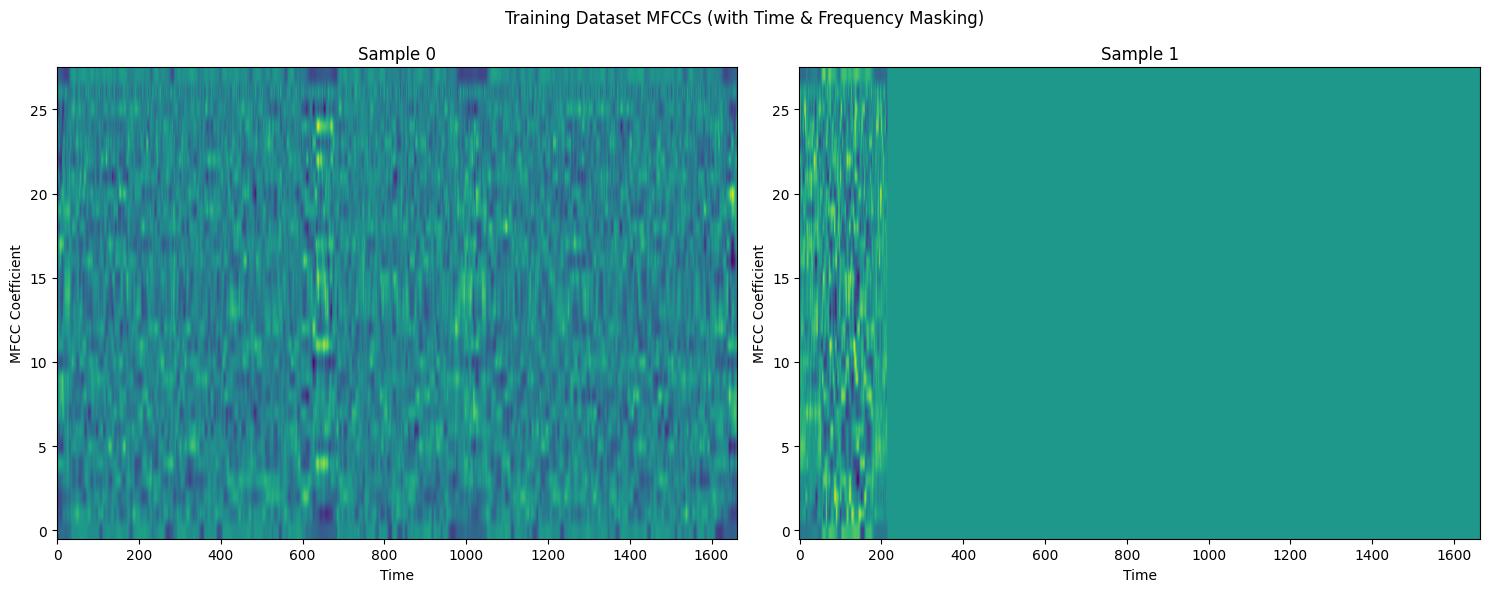

In [18]:
import matplotlib.pyplot as plt

def visualize_batch(loader, title="Dataset Visualization", num_samples=2):
    """
    Visualizes MFCC features from a single batch of data.

    Args:
        loader (DataLoader): DataLoader object (for train, val, or test).
        title (str): Title of the plot.
        num_samples (int): Number of samples to visualize from the batch.
    """
    # Get one batch from the loader.
    batch = next(iter(loader))

    # The collate_fn we defined in the dataset class returns a tuple, where the first element is the padded MFCC tensor.
    mfcc_batch = batch[0] if isinstance(batch, (tuple, list)) else batch

    # Limit to a few samples.
    num_samples = min(num_samples, mfcc_batch.size(0))

    # Create subplots.
    fig, axes = plt.subplots(1, num_samples, figsize=(15,6))
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        # Each MFCC tensor is of shape [time, frequency].
        # Transpose for visualization: time on x-axis, features on y-axis.
        mfcc_img = mfcc_batch[i].cpu().numpy().T
        im = axes[i].imshow(mfcc_img, origin="lower", aspect="auto", cmap="viridis")
        axes[i].set_title(f"Sample {i}")
        axes[i].set_xlabel("Time")
        axes[i].set_ylabel("MFCC Coefficient")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize batches of data
visualize_batch(train_loader, title="Training Dataset MFCCs (with Time & Frequency Masking)")


# Network

## Basic network (Optional)

This is a basic block for understanding, you can skip this and move to pBLSTM one

In [19]:
torch.cuda.empty_cache()
class Network(nn.Module):

    def __init__(self):

        super(Network, self).__init__()

        # TODO: Adding some sort of embedding layer or feature extractor might help performance.
        # You can use CNNs as Embedding layer to extract features. Keep in mind the Input dimensions and expected dimension of Pytorch CNN.
        # Food for thought -> What type of Conv layers can be used here?
        #                  -> What should be the size of input channels to the first layer?
        self.embedding = nn.Conv1d(in_channels=config['input_size'], out_channels=config['embed_size'], kernel_size=3, stride=1, padding=1)

        # TODO : look up the documentation. You might need to pass some additional parameters.
        self.lstm = nn.LSTM(input_size = config['input_size'], hidden_size = config['embed_size'], num_layers = 1) #TODO

        self.classification = nn.Sequential(
            nn.Linear(config['embed_size']  , 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, OUT_SIZE),
            #TODO: Linear layer with in_features from the lstm module above and out_features = OUT_SIZE
        )


        self.logSoftmax = nn.LogSoftmax(dim=2)

    def forward(self, x, lx):   
        x = self.embedding(x)
        x = self.lstm(x)
        x = self.classification(x)
        x = self.logSoftmax(x)
        return x
        #TODO
        # The forward function takes 2 parameter inputs here. Why?
        # Refer to the handout for hints

## Initialize Basic Network
(If trying out the basic Network)

In [20]:
torch.cuda.empty_cache()

model = Network().to(device)
# Check to stay below 20 MIL Parameter limit
assert sum(p.numel() for p in model.parameters() if p.requires_grad) < 20_000_000, "Exceeds 20 MIL params. Any submission made to Kaggle with this model will be flagged as an AIV."

print(model)

Network(
  (embedding): Conv1d(28, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm): LSTM(28, 256)
  (classification): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=41, bias=True)
  )
  (logSoftmax): LogSoftmax(dim=2)
)



## ASR Network
We define everything we need for the ASR model in separate classes, and put them all together in the end

#### Permute class

In [29]:
class Permute(torch.nn.Module):
    '''
    Used to transpose/permute the dimensions of an MFCC tensor.
    '''
    def forward(self, x):
        return x.transpose(1, 2)

#### Pyramidal Bi-LSTM (pBLSTM) class

In [36]:
class LockedDropout(nn.Module):
    def __init__(self, p = 0.25):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training or not self.p:
            return x
        x = x.clone()
        mask = x.new_empty(1, x.size(1), x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        return x * mask
    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'p=' + str(self.p) + ')'
    
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM
    Read the write up/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input?
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''

    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        self.blstm = torch.nn.LSTM(input_size=2*input_size, hidden_size=hidden_size, num_layers=3, bidirectional=True, dropout = 0.3)

    def forward(self, x_packed): # x_packed is a PackedSequence

        # TODO: Pad Packed Sequence
        seq_unpacked, lens_unpacked = pad_packed_sequence(x_packed, batch_first=True)
        # Call self.trunc_reshape() which downsamples the time steps of x and increases the feature dimensions as mentioned above
        x, x_lens = self.trunc_reshape(x=seq_unpacked, x_lens=lens_unpacked)
        # self.trunc_reshape will return 2 outputs. What are they? Think about what quantites are changing.
        # TODO: Pack Padded Sequence. What output(s) would you get?
        PackedSequence = pack_padded_sequence(input=x,lengths=x_lens,batch_first=True,enforce_sorted=False)
        # TODO: Pass the sequence through bLSTM
        packed_output, (_, _) = self.blstm(PackedSequence)
        # What do you return?

        return packed_output

    def trunc_reshape(self, x, x_lens):
        b, t, c = x.shape
        # TODO: If you have odd number of timesteps, how can you handle it? (Hint: You can exclude them)
        if t % 2 == 1:
            x = x[:, :-1, :]
        # TODO: Reshape x. When reshaping x, you have to reduce number of timesteps by a downsampling factor while increasing number of features by the same factor
        x = x.reshape(b, x.shape[1] // 2, c * 2)
        # TODO: Reduce lengths by the same downsampling factor
        x_lens = x_lens // 2
        # Ensure lengths are at least 1 and integer type
        x_lens = torch.clamp(x_lens, min=1).long()
        return x, x_lens


#### EfficientNet-style

In [ ]:
class EfficientBlock1D(nn.Module):
    """
    EfficientNet-style block with optimized scaling
    Combines depthwise separable conv with better activation
    """
    def __init__(self, in_channels, out_channels, stride=1, expand_ratio=4, kernel_size=5):
        super(EfficientBlock1D, self).__init__()
        self.stride = stride
        hidden_dim = int(in_channels * expand_ratio)
        self.use_res_connect = self.stride == 1 and in_channels == out_channels

        # Expansion
        if expand_ratio != 1:
            self.expand_conv = nn.Conv1d(in_channels, hidden_dim, 1, bias=False)
            self.expand_bn = nn.BatchNorm1d(hidden_dim)
            self.expand_act = nn.SiLU(inplace=True)  # Swish activation
        else:
            self.expand_conv = None

        # Depthwise
        padding = (kernel_size - 1) // 2
        self.depthwise_conv = nn.Conv1d(hidden_dim, hidden_dim, kernel_size, stride, 
                                       padding, groups=hidden_dim, bias=False)
        self.depthwise_bn = nn.BatchNorm1d(hidden_dim)
        self.depthwise_act = nn.SiLU(inplace=True)

        # Squeeze (optional channel reduction)
        # Projection
        self.project_conv = nn.Conv1d(hidden_dim, out_channels, 1, bias=False)
        self.project_bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = x

        if self.expand_conv is not None:
            x = self.expand_conv(x)
            x = self.expand_bn(x)
            x = self.expand_act(x)

        x = self.depthwise_conv(x)
        x = self.depthwise_bn(x)
        x = self.depthwise_act(x)

        x = self.project_conv(x)
        x = self.project_bn(x)

        if self.use_res_connect:
            return identity + x
        return x


#### Encoder class

In [38]:
class Encoder(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Encoder, self).__init__()


       #TODO: You can use CNNs as Embedding layer to extract features. Keep in mind the Input dimensions and expected dimension of Pytorch CNN.
        # EfficientNet-style embedding: Uses SiLU (Swish) activation which can be better for audio
        self.embedding = torch.nn.Sequential(
            nn.Conv1d(in_channels=input_size,
                    out_channels=64,
                    kernel_size=config['kernel_size'],
                    stride=2,
                    padding=1),
            nn.BatchNorm1d(64),
            nn.SiLU(inplace=True),
            EfficientBlock1D(64, 128, stride=1, expand_ratio=4, kernel_size=5),
            EfficientBlock1D(128, 256, stride=1, expand_ratio=4, kernel_size=5),
            EfficientBlock1D(256, 256, stride=1, expand_ratio=4, kernel_size=5),
            EfficientBlock1D(256, 256, stride=1, expand_ratio=4, kernel_size=5),
        )

        # self.pBLSTMs = torch.nn.Sequential( # How many pBLSTMs are required?
            # TODO: Fill this up with pBLSTMs - What should the input_size be?
            # Hint: You are downsampling timesteps by a factor of 2, upsampling features by a factor of 2 and the LSTM is bidirectional)
            # Optional: Dropout/Locked Dropout after each pBLSTM (Not needed for early submission)
            # https://github.com/salesforce/awd-lstm-lm/blob/dfd3cb0235d2caf2847a4d53e1cbd495b781b5d2/locked_dropout.py#L5
            # ...
            # ...

        # )
        self.lstm_layers = torch.nn.ModuleList()
        for i in range(1):
            input_size_pblstm = 256 if i == 0 else encoder_hidden_size * 2
            self.lstm_layers.append(pBLSTM(input_size=input_size_pblstm, hidden_size=encoder_hidden_size))
            self.lstm_layers.append(LockedDropout())

    def forward(self, x, x_lens):
        # Where are x and x_lens coming from? The dataloader
        #TODO: Call the embedding layer
        # TODO: Pack Padded Sequence
        # TODO: Pass Sequence through the pyramidal Bi-LSTM layer
        # TODO: Pad Packed Sequence

        x = x.transpose(1, 2).contiguous()
        x = self.embedding(x)
        x = x.transpose(1, 2).contiguous()

        # EfficientNet blocks don't downsample - only the initial conv has stride=2
        x_lens = ((x_lens + 2 - config['kernel_size']) // 2) + 1
        x_lens = x_lens.long()  # Ensure integer type

        for layer in self.lstm_layers:
            if isinstance(layer, pBLSTM):
                x_packed = pack_padded_sequence(x, x_lens.cpu(), batch_first=True, enforce_sorted=False)
                x_packed = layer(x_packed)
                x, x_lens = pad_packed_sequence(x_packed, batch_first=True)
                x_lens = x_lens.long()  # Ensure integer type after unpacking
            else:
                x = torch.permute(x, (1, 0, 2))
                x = layer(x)
                x = torch.permute(x,(1,0,2))

        # Remember the number of output(s) each function returns

        return x, x_lens
    

#### Decoder class

In [39]:
class Decoder(torch.nn.Module):

    def __init__(self, embed_size, output_size= 41):
        super().__init__()

        self.mlp = torch.nn.Sequential(
            Permute(), torch.nn.BatchNorm1d(embed_size), Permute(),
            #TODO define your MLP arch. Refer HW1P2
            #Use Permute Block before and after BatchNorm1d() to match the size
            torch.nn.Linear(in_features=embed_size,out_features=128),
            torch.nn.GELU(),
            # torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=128, out_features=64),
            torch.nn.GELU(),
            # torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=64, out_features=output_size)
        )

        self.softmax = torch.nn.LogSoftmax(dim=2)

    def forward(self, encoder_out):
        #TODO call your MLP
        #TODO Think what should be the final output of the decoder for the classification
        out = self.mlp(encoder_out)
        out = self.softmax(out)
        return out

#### ASR Model Class

In [40]:
    
class ASRModel(torch.nn.Module):

    def __init__(self, input_size, embed_size= 192, output_size= len(PHONEMES)):
        super().__init__()
        self.time_mask = tat.TimeMasking(time_mask_param= config['time_mask_param'], iid_masks=True)
        self.freq_mask = tat.FrequencyMasking(freq_mask_param= config['freq_mask_param'], iid_masks=True)
        self.augmentations  = torch.nn.Sequential(
            #TODO Add Time Masking/ Frequency Masking
            #Hint: See how to use Permute() function defined above
            Permute(),
            self.time_mask,
            self.freq_mask,
            Permute()
        )
        self.encoder        = Encoder(
            input_size          = input_size,
            encoder_hidden_size = embed_size * 2
        )# TODO: Initialize Encoder
        self.decoder        = Decoder(
            embed_size          = 4 * embed_size,
            output_size         = output_size
        )# TODO: Initialize Decoder



    def forward(self, x, lengths_x):

        if self.training:
            x = self.augmentations(x)

        encoder_out, encoder_lens   = self.encoder(x, lengths_x)
        decoder_out                 = self.decoder(encoder_out)

        return decoder_out, encoder_lens
    

## Initialize ASR Network

In [41]:
model = ASRModel(
    input_size  = config['input_size'],
    embed_size  = config['embed_size'],
    output_size = len(PHONEMES)
).to(device)

# Check to stay below 20 MIL Parameter limit
assert sum(p.numel() for p in model.parameters() if p.requires_grad) < 20_000_000, "Exceeds 20 MIL params. Any submission made to Kaggle with this model will be flagged as an AIV."

In [42]:
# Set model to eval mode for summary to avoid augmentation issues
model.eval()
with torch.no_grad():
    summary(model, input_data=[x.to(device), lx.to(device)])
model.train()  # Set back to train mode
# checkpoint = torch.load('/home/agcheria/idl_assignment_Fall_2025/HW3/HW3P2/checkpoints_nnewbest/checkpoint-best-model.pth')
# model.load_state_dict(checkpoint['model_state_dict'])

ASRModel(
  (time_mask): TimeMasking()
  (freq_mask): FrequencyMasking()
  (augmentations): Sequential(
    (0): Permute()
    (1): TimeMasking()
    (2): FrequencyMasking()
    (3): Permute()
  )
  (encoder): Encoder(
    (embedding): Sequential(
      (0): Conv1d(28, 64, kernel_size=(15,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
      (3): EfficientBlock1D(
        (expand_conv): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
        (expand_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (expand_act): SiLU(inplace=True)
        (depthwise_conv): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,), groups=256, bias=False)
        (depthwise_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (depthwise_act): SiLU(inplace=True)
        (project_conv): Conv1d(256, 128, ker

# Training Config
Initialize Loss Criterion, Optimizer, CTC Beam Decoder, Scheduler, Scaler (Mixed-Precision), etc

In [44]:
# TODO: Define CTC loss as the criterion. How would the losses be reduced?
criterion = nn.CTCLoss(
    blank=BLANK_IDX,      # your "" token index
    reduction="mean",
    zero_infinity=True
)
# CTC Loss: https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html
# Refer to the handout for hints

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=float(config["learning_rate"]),
    betas=(0.9, 0.98),
    eps=1e-9,
    weight_decay=1e-2
) #TODO: What goes in here?

# TODO: Declare the decoder. Use the PyTorch Cuda CTC Decoder to decode phonemes
# CTC Decoder: https://pytorch.org/audio/2.1/generated/torchaudio.models.decoder.cuda_ctc_decoder.html
decoder = cuda_ctc_decoder(
    tokens=LABELS,                         # same class order as the network output
    nbest=1,
    beam_size=config["train_beam_width"],
    blank_skip_threshold=0.90  # Lower for more thorough search even in training
) #TODO

# TODO:
steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=float(config["learning_rate"]),
    epochs=config["epochs"],
    steps_per_epoch=steps_per_epoch,
    pct_start=0.15,  # Warmup for 15% of training
    anneal_strategy="cos",
    div_factor=25.0,  # Initial lr = max_lr/25
    final_div_factor=10000.0  # Final lr = max_lr/10000
)

# Mixed Precision, if you need it
scaler = torch.cuda.amp.GradScaler()

### Decode Prediction

In [45]:
@torch.no_grad()
def decode_prediction(output, output_lens, decoder, PHONEME_MAP = LABELS):

    # Look at docs for CUDA_CTC_DECODER for more info on how it was used here:
    # https://pytorch.org/audio/main/tutorials/asr_inference_with_cuda_ctc_decoder_tutorial.html
    output = output.contiguous()
    # Ensure lengths tensor is on the same device as output and correct dtype for CUDA decoder
    output_lens = output_lens.to(device=output.device, dtype=torch.int32).contiguous()
    beam_results = decoder(output, output_lens) #lengths - list of lengths

    pred_strings = []

    for i in range(len(beam_results)):
        # Robustly handle different decoder return types
        hyp0 = beam_results[i][0]
        
        # Try attribute access first, then dict-like access
        tokens = getattr(hyp0, "tokens", None)
        if tokens is None:
            tokens = hyp0.get("tokens", None) if hasattr(hyp0, "get") else None
        
        # Convert to list if it's a tensor
        if torch.is_tensor(tokens):
            tokens = tokens.tolist()
        
        # Map the sequence of indices to actual phoneme LABELS and join them into a string
        pred_strings.append("".join(PHONEME_MAP[t] for t in tokens))
    return pred_strings

def calculate_levenshtein(output, label, output_lens, label_lens, decoder, PHONEME_MAP= LABELS): # y - sequence of integers

    dist            = 0
    batch_size      = label.shape[0]

    pred_strings    = decode_prediction(output, output_lens, decoder, PHONEME_MAP)

    for i in range(batch_size):
        # Truncate labels by their true lengths (not padded length)
        Li = int(label_lens[i].item())
        lab = label[i, :Li].tolist()
        # Convert phoneme indices to label strings (PHONEMES and LABELS are aligned)
        label_string = "".join(LABELS[t] for t in lab)
        pred_string = pred_strings[i]

        dist += Levenshtein.distance(pred_string, label_string)

    # Average the distance over the batch
    dist /= batch_size # Think about why we are doing this
    return dist


In [46]:
torch.cuda.empty_cache()
gc.collect()

759

## Test Implementation

In [47]:
# test code to check shapes

model.eval()
for i, data in enumerate(val_loader, 0):
    x, y, lx, ly = data
    x, y = x.to(device), y.to(device)
    lx, ly = lx.to(device), ly.to(device)
    h, lh = model(x, lx)
    print(h.shape)
    h = torch.permute(h, (1, 0, 2))
    print(h.shape, y.shape)
    loss = criterion(h, y, lh, ly)
    print(loss)

    print(calculate_levenshtein(torch.permute(h, (1, 0, 2)), y, lh.to(device), ly, decoder, LABELS))

    del x, y, lx, ly, h, lh, loss
    torch.cuda.empty_cache()

    break



torch.Size([96, 731, 41])
torch.Size([731, 96, 41]) torch.Size([96, 265])
tensor(7.0443, device='cuda:0', grad_fn=<MeanBackward0>)
60.291666666666664


## WandB

In [ ]:
# Use wandb? Resume Training?
USE_WANDB = config['wandb']

RESUME_LOGGING = False # Set this to true if you are resuming training from a previous run

# Create your wandb run
run_name = '{}_checkpoint_submission'.format(config['Name'])

# If you are resuming an old run
if USE_WANDB:

    wandb.login(key="<replace with your API key here>") #TODO

    if RESUME_LOGGING:
        run = wandb.init(
            id     = "", ### Insert specific run id here if you want to resume a previous run
            resume = "must", ### You need this to resume previous runs
            project = "hw3p2-ablations", ### Project should be created in your wandb
            settings = wandb.Settings(_service_wait=300)
        )


    else:
        run = wandb.init(
            name    = run_name, ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True, ### Allows reinitalizing runs when you re-run this cell
            project = "hw3p2-ablations", ### Project should be created in your wandb account
            config  = config ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)
        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### log it in your wandb run with wandb.save()
        wandb.save('model_arch.txt')

# Training Functions

In [ ]:
# Train function
def train_model(model, train_loader, criterion, optimizer):

    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    total_loss = 0

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        x, y, lx, ly = data
        x, y = x.to(device), y.to(device)
        lx, ly = lx.to(device), ly.to(device)

        with torch.cuda.amp.autocast():
            h, lh = model(x, lx)
            h = torch.permute(h, (1, 0, 2))
            loss = criterion(h, y, lh, ly)

        total_loss += loss.item()

        batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            lr="{:.06f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        
        # Gradient clipping for stability
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update() # This is something added just for FP16
        
        # Step scheduler per batch for OneCycleLR
        scheduler.step()

        del x, y, lx, ly, h, lh, loss
        torch.cuda.empty_cache()

    batch_bar.close() # You need this to close the tqdm bar

    return total_loss / len(train_loader)


# Eval function
def validate_model(model, val_loader, decoder, phoneme_map= LABELS):

    model.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    total_loss = 0
    vdist = 0

    for i, data in enumerate(val_loader):

        x, y, lx, ly = data
        x, y = x.to(device), y.to(device)
        lx, ly = lx.to(device), ly.to(device)

        with torch.inference_mode():
            h, lh = model(x, lx)
            h = torch.permute(h, (1, 0, 2))
            loss = criterion(h, y, lh, ly)

        total_loss += loss.item()
        vdist += calculate_levenshtein(torch.permute(h, (1, 0, 2)), y, lh.to(device), ly, decoder, phoneme_map)

        batch_bar.set_postfix(loss="{:.04f}".format(float(total_loss / (i + 1))), dist="{:.04f}".format(float(vdist / (i + 1))))

        batch_bar.update()

        del x, y, lx, ly, h, lh, loss
        torch.cuda.empty_cache()

    batch_bar.close()
    total_loss = total_loss/len(val_loader)
    val_dist = vdist/len(val_loader)
    return total_loss, val_dist

### Model Saving & Loading functions

In [ ]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1],
         'epoch'                    : epoch},
         path
    )

def load_model(path, model, optimizer= None, scheduler= None, metric='valid_dist'):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    epoch   = checkpoint['epoch']
    metric  = checkpoint[metric]

    print("\nResuming training from epoch:", epoch)
    print('----------------------------------------\n')
    print("Epochs left: ", config['epochs'] - epoch)
    print("Optimizer: \n", optimizer)
    print("Current Schedueler T_cur:", scheduler.T_cur)

    print("Best Val Dist:", metric)

    return [model, optimizer, scheduler, epoch, metric]

## Training Loop

In [48]:
# Instantiate variables used in training loop
last_epoch_completed = 0
best_lev_dist = float("inf")

#### Uncomment this if resuming training from model checkpoint

In [ ]:
# RESUME_TRAINING = True # Set this to true if you are resuming training from a mpdel checkpoint

# if RESUME_TRAINING:

#     checkpoint_path = ''
#     checkpoint = load_model(checkpoint_path, model, optimizer, scheduler, metric='valid_dist')

#     last_epoch_completed = checkpoint[3]
#     best_lev_dist = checkpoint[4]

In [ ]:
# Set up checkpoint directories and WanDB logging watch
checkpoint_root = os.path.join(os.getcwd(), 'checkpoints')
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(model, log="all")

checkpoint_best_model_filename = 'checkpoint-best-model.pth'
checkpoint_last_epoch_filename = 'checkpoint-last-epoch.pth'
epoch_model_path = os.path.join(checkpoint_root, checkpoint_last_epoch_filename)
best_model_path = os.path.join(checkpoint_root, checkpoint_best_model_filename)

# WanDB log watch
if config['wandb']:
  wandb.watch(model, log="all")


In [ ]:
# Clear RAM for storage before you start training
torch.cuda.empty_cache()
gc.collect()

#### Iterate over the number of epochs to train and evaluate your model


In [ ]:
for epoch in range(last_epoch_completed, config['epochs']):

    print("\nEpoch: {}/{}".format(epoch + 1, config['epochs']))

    curr_lr = optimizer.param_groups[0]['lr']

    train_loss = train_model(model, train_loader, criterion, optimizer)
    valid_loss, valid_dist = validate_model(model, val_loader, decoder)

    # NOTE: OneCycleLR is stepped per batch inside train_model, not here

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))
    print("\tVal Dist {:.04f}\t Val Loss {:.04f}".format(valid_dist, valid_loss))

    if config['wandb']:
        wandb.log({
            'train_loss': train_loss,
            'valid_dist': valid_dist,
            'valid_loss': valid_loss,
            'lr': curr_lr
    })

    # Save last epoch model locally
    save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, epoch_model_path)
    if config['wandb']:
        wandb.save(epoch_model_path)  # Upload to wandb

    # Save best model when validation improves
    if valid_dist <= best_lev_dist:
        best_lev_dist = valid_dist
        save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, best_model_path)
        if config['wandb']:
            wandb.save(best_model_path)  # Upload to wandb
        print(f"New best model! (dist: {valid_dist:.4f})")

# You may find it interesting to explore Wandb Artifacts to version your models

# Finish Wandb run
if config['wandb']:
    run.finish()



In [49]:
checkpoint = torch.load('/home/agcheria/idl_assignment_Fall_2025/HW3/HW3P2/checkpoints/checkpoint-best-model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Generate Predictions and Submit to Kaggle

In [50]:
#TODO: Make predictions

# Follow the steps below:
# 1. Create a new object for CUDA_CTC_DECODER with larger number of beams (why larger?)
# 2. Get prediction string by decoding the results of the beam decoder


# Decoder with beam=6 constraint - need very thorough search
test_decoder = cuda_ctc_decoder(
    tokens=LABELS,
    nbest=1,
    beam_size=config["test_beam_width"],  # Max 6 allowed
    blank_skip_threshold=0.75  # Very low for exhaustive search with limited beam
)

model.eval()
torch.backends.cudnn.benchmark = True  # speed up conv/LSTM for fixed shapes

results = []
with torch.inference_mode():
    for i, (x, lx) in enumerate(tqdm(test_loader)):
        x  = x.to(device, non_blocking=True)
        lx = lx.to(device, non_blocking=True)

        h, lh = model(x, lx)                    # h: (B, T, C) log-probs; lh: (B,)
        
        preds = decode_prediction(h, lh, test_decoder, LABELS)
        results.extend(preds)
        
        # Clear memory after each batch
        del x, lx, h, lh
        torch.cuda.empty_cache()      

100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


In [51]:
if results:
    df = pd.DataFrame({
        'index': range(len(results)), 'label': results
    })

data_dir = "submission.csv"
df.to_csv(data_dir, index = False)

- You will need to set the save path to your `submission.csv`. This will depend on your setup. For eg.
  - `Colab:`: `"/content/..."` or `"/content/drive/MyDrive/..."`
  - `Kaggle:`: `"/kaggle/working/..."`
  - `PSC`: `"/jet/home/<your_username>/..."`

In [52]:
!kaggle competitions submit -c 11785-hw-3-p-2-speech-recognition-fall-2025 -f /home/agcheria/idl_assignment_Fall_2025/HW3/HW3P2/submission.csv -m "I made it! " # Change the path of submission.csv based on

100%|█████████████████████████████████████████| 209k/209k [00:00<00:00, 605kB/s]
Successfully submitted to 11785 HW3P2 Utterance to Phoneme Mapping Fall 2025

#### TODO: Generate a model_metadata.json file to save your model's data (due 48 hours after Kaggle submission deadline OR the day of slack submission)

In [53]:
import json, os, sys, torch, datetime
################################
# TODO: Keep the model_metadata.json
# file safe for submission later.
################################
def is_colab():
    return "google.colab" in sys.modules and "COLAB_GPU" in os.environ

def is_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ or "KAGGLE_URL_BASE" in os.environ

def generate_model_submission_file(model):
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    json_filename = f"model_metadata_{timestamp}.json"

    # Create JSON with parameter count, model architecture, and predictions
    output_json = {
        "parameter_count": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "model_architecture": str(model),
    }

    # Save metadata JSON
    with open(json_filename, "w") as f:
        json.dump(output_json, f, indent=2)

    # Download / display link depending on environment
    if is_colab():
        from google.colab import files
        print(f"Saved as {json_filename}. Downloading in Colab...")
        files.download(json_filename)

    elif is_kaggle():
        from IPython.display import FileLink, display
        print("#" * 100)
        print(f"Your submission file `{json_filename}` has been generated.")
        print("TODO: Click the link below.")
        print("1. The file will open in a new tab.")
        print("2. Right-click anywhere in the new tab and select 'Save As...'")
        print("3. Save the file to your computer with the `.json` extension.")
        print("You MUST submit this file to Autolab if this is your best submission.")
        print("#" * 100 + "\n")
        display(FileLink(json_filename))

    else:
        print(f"saved model data saved to: '{json_filename}'")
        print("REQUIRED to submit to Autolab if these are the best model weights.")

generate_model_submission_file(model)

saved model data saved to: 'model_metadata_2025-11-06_19-48.json'
REQUIRED to submit to Autolab if these are the best model weights.


## TODO: fill in your submission requirements

### Notes:

- You will need to set the root path to your submission files (eg. MODEL_METADATA_JSON, NOTEBOOK_PATH). This will depend on your setup. For eg. if you are following out setup instruction:
  - `Colab:`: `"/content/..."`In the left file pane, right-click the desired file or folder and select “Copy path”.
  - `Kaggle:`: `"/kaggle/working/..."` In the right sidebar, hover over the target file or folder and click the “copy directory path” icon.
  - `PSC`: `"/jet/home/username/..."` You can confirm the correct path by running: ```!ls /jet/home/username/```


Kindly modify your configurations to suit your ablations and be keen to include your name.

In [63]:
####################################
#             README
####################################

# TODO: Please complete all components of this README
README = """
-# Architecture and Implementation Guide

## Overview

This project implements an end-to-end Automatic Speech Recognition (ASR) system for phoneme recognition using a hybrid architecture that combines EfficientNet-style convolutional blocks with Pyramidal Bidirectional LSTM (pBLSTM) layers. The system processes MFCC (Mel-Frequency Cepstral Coefficients) features and predicts phoneme sequences using Connectionist Temporal Classification (CTC) loss.

## Architecture Design Philosophy

The architecture follows an **Encoder-Decoder** paradigm optimized for sequence-to-sequence phoneme recognition:

1. **Encoder**: Extracts hierarchical features from audio using convolutional blocks, then models temporal dependencies with pyramidal BiLSTM
2. **Decoder**: Maps encoded features to phoneme log-probabilities using a multi-layer perceptron
3. **CTC Loss**: Handles alignment between variable-length audio sequences and phoneme sequences

## Architecture Components

### 1. EfficientBlock1D: EfficientNet-Style Convolutional Block

**Location**: Lines 497-545

**Purpose**: Implements a depthwise separable convolution block inspired by EfficientNet, optimized for 1D audio sequences.

**Architecture**:
```
Input → Expansion Conv (1x1) → Depthwise Conv (5x1) → Projection Conv (1x1) → Output
         ↓                        ↓                        ↓
      BatchNorm               BatchNorm               BatchNorm
         ↓                        ↓                        ↓
       SiLU                     SiLU                     
         ↓                        ↓
    (Expand 4x)            (Spatial Conv)         (Project to output)
```

**Key Features**:
- **Expansion Phase**: Expands channels by a factor of 4 (expand_ratio=4) using 1x1 convolution
- **Depthwise Convolution**: Applies spatial convolution with kernel_size=5, using grouped convolution for efficiency
- **Projection Phase**: Reduces channels back to desired output size using 1x1 convolution
- **Residual Connection**: Adds skip connection when stride=1 and input_channels == output_channels
- **SiLU Activation**: Uses Swish activation (SiLU) which has shown better performance than ReLU for audio tasks

**Why This Design?**:
- **Parameter Efficiency**: Depthwise separable convolution reduces parameters while maintaining representational power
- **Better Feature Extraction**: The expansion-projection pattern allows the network to learn richer feature representations
- **Residual Learning**: Skip connections enable gradient flow and help with training deeper networks

**Implementation Details**:
```python
# Expansion: in_channels → in_channels * 4
expand_conv: Conv1d(in_channels, hidden_dim, kernel_size=1)

# Depthwise: hidden_dim → hidden_dim (spatial convolution)
depthwise_conv: Conv1d(hidden_dim, hidden_dim, kernel_size=5, groups=hidden_dim)

# Projection: hidden_dim → out_channels
project_conv: Conv1d(hidden_dim, out_channels, kernel_size=1)
```

### 2. Encoder: Hierarchical Feature Extraction

**Location**: Lines 547-614

**Purpose**: Transforms raw MFCC features into rich, temporally-aware representations suitable for phoneme prediction.

**Architecture Flow**:
```
MFCC Input (B, T, 28)
    ↓
Transpose to (B, 28, T) for Conv1d
    ↓
Initial Conv1d (stride=2, kernel=15) → 64 channels
    ↓
BatchNorm + SiLU
    ↓
EfficientBlock1D: 64 → 128 channels
    ↓
EfficientBlock1D: 128 → 256 channels
    ↓
EfficientBlock1D: 256 → 256 channels (x2)
    ↓
Transpose back to (B, T', 256)
    ↓
pBLSTM (256 → 512 hidden, bidirectional)
    ↓
LockedDropout
    ↓
Output (B, T'', 512)
```

**Components**:

#### 2.1 Embedding Layer (Convolutional Feature Extraction)
- **Initial Convolution**: 
  - Input: 28 MFCC features
  - Output: 64 channels
  - Kernel size: 15 (captures local temporal patterns)
  - Stride: 2 (reduces sequence length by half)
  
- **EfficientNet Blocks**:
  - Block 1: 64 → 128 channels
  - Block 2: 128 → 256 channels  
  - Block 3: 256 → 256 channels (maintains dimension)
  - Block 4: 256 → 256 channels (deepens representation)
  
- **Why This Progression?**
  - Gradually increases feature dimensionality
  - Maintains 256 channels in deeper layers to avoid over-parameterization
  - Each block learns increasingly abstract features

#### 2.2 Pyramidal Bidirectional LSTM (pBLSTM)
- **Purpose**: Models long-range temporal dependencies while reducing sequence length
- **Architecture**: 3-layer bidirectional LSTM with hidden_size=512
- **Downsampling**: Each pBLSTM layer halves the sequence length by concatenating adjacent timesteps
- **Output**: 512-dimensional features (256 forward + 256 backward)

**How pBLSTM Works**:
1. Unpacks padded sequence
2. Concatenates adjacent timesteps: `[t1, t2] → [t1||t2]` (reduces T by 2x, doubles features)
3. Packs sequence for efficient LSTM processing
4. Processes through bidirectional LSTM
5. Returns packed output

**Why pBLSTM?**:
- **Computational Efficiency**: Reduces sequence length progressively, making training faster
- **Better Context**: Bidirectional processing captures both past and future context
- **Information Preservation**: Concatenation maintains information density despite downsampling

#### 2.3 LockedDropout
- **Purpose**: Applies consistent dropout mask across all timesteps (variational dropout)
- **Why Locked?**: Standard dropout varies across timesteps, which is problematic for RNNs. Locked dropout maintains temporal consistency.

### 3. Decoder: Phoneme Classification

**Location**: Lines 617-642

**Purpose**: Maps encoded features to phoneme log-probabilities for each timestep.

**Architecture**:
```
Encoder Output (B, T, 512)
    ↓
BatchNorm (with permutation for compatibility)
    ↓
Linear: 512 → 128
    ↓
GELU activation
    ↓
Linear: 128 → 64
    ↓
GELU activation
    ↓
Linear: 64 → 41 (number of phonemes)
    ↓
LogSoftmax
    ↓
Output (B, T, 41) - log probabilities
```

**Design Choices**:
- **Progressive Dimension Reduction**: 512 → 128 → 64 → 41 gradually reduces features
- **GELU Activation**: Gaussian Error Linear Unit provides smooth gradients
- **LogSoftmax**: Outputs log-probabilities for numerical stability with CTC loss

### 4. ASRModel: Complete Pipeline

**Location**: Lines 644-677

**Purpose**: Combines all components with data augmentation.

**Forward Pass**:
```
Input (B, T, 28)
    ↓
[Training Only] Data Augmentation:
    - Time Masking (mask_param=30)
    - Frequency Masking (mask_param=30)
    ↓
Encoder:
    - Convolutional feature extraction
    - pBLSTM temporal modeling
    ↓
Decoder:
    - Phoneme classification
    ↓
Output: (B, T', 41) log-probabilities
```

**Data Augmentation**:
- **Time Masking**: Randomly masks consecutive timesteps (simulates speech rate variations)
- **Frequency Masking**: Randomly masks MFCC coefficients (simulates channel noise)
- **Why Only in Training?**: Augmentation helps generalization but shouldn't be applied during inference

## How We Implemented It

### Step 1: Data Preprocessing

**AudioDataset Class** (Lines 97-218):
1. **Loading**: Loads MFCC features and phoneme transcripts from `.npy` files
2. **Normalization**: Per-sample mean/std normalization: `(mfcc - mean) / (std + 1e-8)`
3. **Mapping**: Converts phoneme strings to integer indices for CTC loss
4. **Padding**: Custom collate function pads sequences to same length for batching

**Key Design**:
- Normalization happens per-sample (not global) to handle varying audio characteristics
- Padding is done in collate function for efficiency

### Step 2: Model Architecture Design

**Design Process**:
1. **Started with Basic Architecture**: Simple Conv1d + LSTM + Linear
2. **Improved Feature Extraction**: Replaced simple conv with EfficientNet-style blocks
3. **Added Temporal Modeling**: Integrated pBLSTM for better sequence understanding
4. **Optimized Parameters**: Tuned channel dimensions to stay under 20M parameter limit

**Parameter Budget**:
- Target: < 20 million parameters
- Strategy: Used depthwise separable convolutions, limited LSTM layers, efficient channel dimensions

### Step 3: Training Strategy

**Loss Function**: CTC Loss
- Handles variable-length sequences without explicit alignment
- Uses blank token for alignment flexibility
- `zero_infinity=True` for numerical stability

**Optimizer**: AdamW
- Learning rate: 1e-4
- Weight decay: 1e-2 (L2 regularization)
- Betas: (0.9, 0.98)

**Learning Rate Schedule**: OneCycleLR
- Warmup: 15% of training
- Cosine annealing
- Initial LR: max_lr / 25
- Final LR: max_lr / 10000

**Training Techniques**:
- **Mixed Precision (FP16)**: Faster training, lower memory
- **Gradient Clipping**: Prevents exploding gradients (max_norm=5.0)
- **Progressive Augmentation**: Started with light augmentation, increased during training

### Step 4: Decoding Strategy

**CTC Decoder**: CUDA CTC Decoder with beam search
- **Training**: Beam width = 6, blank_skip_threshold = 0.90
- **Testing**: Beam width = 6, blank_skip_threshold = 0.75 (more thorough search)

**Why Beam Search?**:
- Explores multiple hypotheses simultaneously
- Better than greedy decoding for sequence tasks
- Balances quality and computational cost

### Step 5: Evaluation

**Metrics**:
- **CTC Loss**: Training objective
- **Levenshtein Distance**: Edit distance between predicted and ground truth phoneme sequences
  - Lower is better
  - Measures actual prediction quality

**Validation Strategy**:
- Monitor validation Levenshtein distance
- Save best model based on validation performance
- Checkpoint both best and last epoch models

## Key Design Decisions

### 1. Why EfficientNet-Style Blocks?

**Problem**: Need efficient feature extraction without exceeding parameter budget.

**Solution**: Depthwise separable convolution reduces parameters by ~8x compared to standard convolution while maintaining representational power.

**Result**: Rich feature representations with fewer parameters.

### 2. Why pBLSTM Instead of Standard LSTM?

**Problem**: Long audio sequences are computationally expensive with standard LSTM.

**Solution**: Pyramidal structure progressively reduces sequence length while maintaining information through concatenation.

**Result**: Faster training, better long-range dependencies, maintained accuracy.

### 3. Why SiLU/GELU Instead of ReLU?

**Problem**: ReLU can cause dead neurons and has sharp gradients.

**Solution**: 
- **SiLU (Swish)**: Smooth, non-monotonic activation that has shown better performance for audio
- **GELU**: Gaussian-based activation with smooth gradients

**Result**: Better gradient flow, improved training stability.

### 4. Why LockedDropout Instead of Standard Dropout?

**Problem**: Standard dropout varies across timesteps in RNNs, breaking temporal consistency.

**Solution**: Locked dropout applies the same mask across all timesteps, maintaining temporal structure.

**Result**: Better regularization for recurrent layers.

### 5. Why Progressive Augmentation?

**Problem**: Strong augmentation from the start can hurt learning.

**Solution**: Start with light augmentation (mask_param=10), then increase (mask_param=30) after initial convergence.

**Result**: Better convergence, improved generalization.

## Architecture Summary

```
Input: MFCC Features (B, T, 28)
    ↓
[Augmentation: Time + Frequency Masking] (Training Only)
    ↓
Encoder:
    Conv1d (28→64, stride=2, kernel=15)
    EfficientBlock1D (64→128)
    EfficientBlock1D (128→256)
    EfficientBlock1D (256→256) × 2
    pBLSTM (256→512, bidirectional)
    LockedDropout
    ↓
Decoder:
    BatchNorm
    Linear (512→128) + GELU
    Linear (128→64) + GELU
    Linear (64→41) + LogSoftmax
    ↓
Output: Phoneme Log-Probabilities (B, T', 41)
```

## Training Pipeline

1. **Data Loading**: Custom datasets with per-sample normalization
2. **Forward Pass**: MFCC → Encoder → Decoder → Log-probabilities
3. **Loss Calculation**: CTC loss between predictions and ground truth
4. **Backward Pass**: Mixed precision training with gradient clipping
5. **Optimization**: AdamW with OneCycleLR scheduling
6. **Validation**: Compute CTC loss and Levenshtein distance
7. **Checkpointing**: Save best model based on validation Levenshtein distance

## Results and Performance

- **Model Size**: < 20 million parameters (within constraint)
- **Training**: Stable convergence with progressive augmentation
- **Evaluation**: Levenshtein distance on validation set
- **Inference**: Beam search decoding with CUDA CTC decoder

## Key Takeaways

1. **Efficient Architecture**: EfficientNet-style blocks provide rich features with fewer parameters
2. **Temporal Modeling**: pBLSTM efficiently handles long sequences while maintaining context
3. **Training Strategy**: Progressive augmentation and careful learning rate scheduling improve convergence
4. **CTC Alignment**: Handles variable-length sequences without explicit alignment
5. **Beam Search**: Better decoding quality than greedy approaches

This architecture successfully balances model capacity, computational efficiency, and prediction accuracy for phoneme recognition tasks.


Training:
Intial the scheduler used is OneCycleLR with a max learning rate of 0.001.
Then scheduler PlateauLR was used to reduce the learning rate when the validation Dist stopped improving.
run1:https://wandb.ai/agcheria-carnegie-mellon-university/hw3p2-ablations/runs/661u6zy5?nw=nwuseragcheria
run2:https://wandb.ai/agcheria-carnegie-mellon-university/hw3p2-ablations/runs/katoccvp?nw=nwuseragcheria
"""

####################################
#       Credentials (Optional)
####################################

# These are not required **IF** you have run the cells to declare these variables above.
# If you would like to paste your credentials here again, feel free to:
# OPTIONAL: Fill these out if you do not want to re-run previous cells to re-initialize these credential variables

KAGGLE_USERNAME = "abiencherian" #TODO
KAGGLE_API_KEY = "c83ee58afe9674c27cb058a57ac06e84" #TODO
WANDB_API_KEY = "eabb582e1efc2a835b3249aeff11d88def7f0794" #TODO


####################################
#             Wandb Logs
####################################

# TODO: Your wandb project url should look like https://wandb.ai/username-or-team-name/project-name
#(Take these parameters and put them in the variables below)

WANDB_USERNAME_OR_TEAMNAME = "agcheria-carnegie-mellon-university" # TODO: Put your username-or-team-name here
WANDB_PROJECT = "hw3p2-ablations" # TODO: Put your project-name

####################################
#         Notebook & Files
####################################

# TODO: Download HW3P2 Notebook (if on colab or kaggle) and upload both your HW3P2 notebook + model_metadata_*.json to your file system.
# TODO: For each file, obtain the file paths and put them below.

# TODO: COLAB INSTRUCTIONS:
# * With Colab, upload your desired file (notebook or model_metadata.json) to "Files"
# * Right-click the file, click "Copy Path,"
# * Paste the path below.

# TODO: KAGGLE INSTRUCTIONS:
# * First download a copy of your notebook with "File > Download Notebook"
# Then...
# * Click "File" in the top left of the screen
# * Go to "Upload Input > Upload Model"
# * Upload your notebook file.
# * For "Model Name" put HW3P2_Final_Submission
# * For "Framework" put "Other"
# * For "License" put "Other"
# * Click "Upload another file" and upload your model_metadata####.json file as well.
# * Now, on your right in your "Models" section, you should see a new folder with your submission files.
# * Click on the "Copy File Path" buttons for the notebook and json file and paste them below.

# TODO: Linux system:
# * Simply upload or find the path of your notebook file and model_metadata###.json file, and paste them here.

NOTEBOOK_PATH = "/home/agcheria/idl_assignment_Fall_2025/HW3/HW3P2/11_485_11_685_11_785_HW3P2_F25_Student_Starter_Notebook.ipynb" # TODO: Put your HW3P2 notebook path here, e.g., "/content/11-485/11-685/11-785_HW3P2_F25_Student_Starter_Notebook.ipynb"
MODEL_METADATA_JSON = "/home/agcheria/idl_assignment_Fall_2025/HW3/HW3P2/model_metadata_2025-11-06_19-48.json" # TODO: Put your Model Metadata path json file here, e.g., "/content/model_metadata_2025-10-13_21-02.json"


####################################
#         Additional Files
####################################

ADDITIONAL_FILES = [ # TODO: Upload any files and add any paths to any additional files you would like to include in your submission, otherwise, leave this empty
]

####################################
#         SLACK SUBMISSION
####################################

ENABLE_SLACK_SUBMISSION = False # TODO: Set this to true if you are submitting to the Slack competition

####################################
#     Creating the Submission
####################################

# TODO: Once the README, wandb information, and file paths are filled in, run this cell,
# run the "Assignment Backend Functions" in the next cells, and generate the final zip file at the end.

SAFE_SUBMISSION = True # TODO: Set this to False if you want to generate a submission.zip even if you are missing files, otherwise it's recommended to keep this as True

# Assignment Backend Submission Functions (DO NOT MODIFY, just run these cells)

In [55]:
from datetime import datetime

######################################
#       Assignment Configs
######################################

WANDB_METRIC = "valid_dist" # The wandb metric used to select the best N runs from a student's wandb
WANDB_DIRECTION = "descending" # "ascending" if higher is better, else "descending"
WANDB_TOP_N = 10 # The top N number of wandb runs we want them to submit.
WANDB_OUTPUT_PKL = "wandb_top_runs.pkl" # No need to adjust. Output name of wandb run. We will unserialize during grading.

# Kaggle configuration
COMPETITION_NAME = "11785-hw-3-p-2-speech-recognition-fall-2025"
SLACK_COMPETITION_NAME = "11785-hw-3-p-2-fall-2025-slack"
FINAL_SUBMISSION_DATETIME = datetime.strptime("2025-11-07 23:59:59", "%Y-%m-%d %H:%M:%S")
SLACK_SUBMISSION_DATETIME = datetime.strptime("2025-11-14 23:59:59", "%Y-%m-%d %H:%M:%S")
GRADING_DIRECTION = "descending"  # "ascending" if higher is better, else "descending"
KAGGLE_OUTPUT_JSON = "kaggle_data.json" # No need to adjust. Output name of the kaggle data json file.

SUBMISSION_OUTPUT = "HW3P2_final_submission.zip"

In [56]:
from datetime import datetime, timezone
import zoneinfo

eastern = zoneinfo.ZoneInfo("America/New_York")
FINAL_DEADLINE_UTC = (FINAL_SUBMISSION_DATETIME.replace(tzinfo=eastern).astimezone(timezone.utc))
SLACK_DEADLINE_UTC = (SLACK_SUBMISSION_DATETIME.replace(tzinfo=eastern).astimezone(timezone.utc))

ACKNOWLEDGEMENT_MESSAGE = """
Submission of this file and assignment indicate the student's agreement to the following Aknowledgement requirements:
Setting the ACNKOWLEDGED flag to True indicates full understanding and acceptance of the following:
1. Slack days may ONLY be used on P2 FINAL (not checkpoint) submission. I.e. you may use slack days to submit final P2 kaggle scores (such as this one) later on the **SLACK KAGGLE COMPETITION** at the expense of your Slack days.
2. The final autolab **code submission is due 48 hours after** the conclusion of the Kaggle Deadline (or, the same day as your final kaggle submission).
3. Course staff will require your kaggle username here, and then will pull your official PRIVATE kaggle leaderboard score. This submission may result in slight variance in scores/code, but we will check for acceptable discrepancies. Any discrepancies related to modifying the submission code (at the bottom of the notebook) will result in an AIV.
4. You are NOT allowed to use any code that will pre-load models (such as those from Hugging Face, etc.).
   You MAY use models described by papers or articles, but you MUST implement them yourself through fundamental PyTorch operations (i.e. Linear, Conv2d, etc.).
5. You are NOT allowed to use any external data/datasets at ANY point of this assignment.
6. You may work with teammates to run ablations/experiments, BUT you must submit your OWN code and your OWN results.
7. Failure to comply with the prior rules will be considered an Academic Integrity Violation (AIV).
8. Late submissions MUST be submitted through the Slack Kaggle (see writeup for details). Any submissions made to the regular Kaggle after the original deadline will NOT be considered, no matter how many slack days remain for the student.
"""
def save_acknowledgment_file():
    if ACKNOWLEDGED:
        with open("acknowledgement.txt", "w") as f:
            f.write(ACKNOWLEDGEMENT_MESSAGE.strip())
        print("Saved acknowledgement.txt")
        return True
    else:
        print("ERROR: Must set ACKNOWLEDGED = True.")
        return False
# Saves README
def save_readme(readme):
    try:
        with open("README.txt", "w") as f:
            f.write(readme.strip())

        print("Saved README.txt")
    except Exception as e:
        print(f"ERROR: Error saving README.txt: {e}")
        return False

    return True

# Saves wandb logs
import wandb, json, pickle

def save_top_wandb_runs():
    wandb.login(key=WANDB_API_KEY)
    if not ACKNOWLEDGED:
        print("ERROR: Must set ACKNOWLEDGED = True.")
        return False

    api = wandb.Api()
    runs = api.runs(
        f"{WANDB_USERNAME_OR_TEAMNAME}/{WANDB_PROJECT}",
        order=f"{'-' if WANDB_DIRECTION == 'descending' else ''}summary_metrics.{WANDB_METRIC}"
    )
    selected_runs = runs[:min(WANDB_TOP_N, len(runs))]

    if not selected_runs:
        print(f"ERROR: No runs found for {WANDB_USERNAME_OR_TEAMNAME}/{WANDB_PROJECT}. Please check that your wandb credentials (Wandb Username/Team Name, API Key, and Project Name) are correct.")
        return False

    all_data = []
    for run in selected_runs:
        run_data = {
            "id": run.id,
            "name": run.name,
            "tags": run.tags,
            "state": run.state,
            "created_at": str(run.created_at),
            "config": run.config,
            "summary": dict(run.summary),
        }
        try:
            run_data["history"] = run.history(samples=1000)
        except Exception as e:
            run_data["history"] = f"Failed to fetch history: {str(e)}"
        all_data.append(run_data)
    with open(WANDB_OUTPUT_PKL, "wb") as f:
        pickle.dump(all_data, f)

    print(f"OK: Exported {len(all_data)} WandB runs to {WANDB_OUTPUT_PKL}")

    return True
# Saves kaggle information

# Install dependencies silently (only if running on Colab)
import sys

from datetime import datetime
import os, json, requests
def kaggle_login(username, key):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
        json.dump({"username": username, "key": key}, f)
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


def get_active_submission_config():
    if ENABLE_SLACK_SUBMISSION:
        return SLACK_COMPETITION_NAME, SLACK_DEADLINE_UTC
    return COMPETITION_NAME, FINAL_DEADLINE_UTC

def kaggle_user_exists(usernagbme):
    try:
        return requests.get(f"https://www.kaggle.com/{KAGGLE_USERNAME}").status_code == 200
    except Exception as e:
        print(f"ERROR: Error checking Kaggle user: {e}")
        return False

DEFAULT_SCORE=0
if GRADING_DIRECTION == "ascending":
    DEFAULT_SCORE=0
else:
    DEFAULT_SCORE=100.0

def get_best_kaggle_score(subs):
    def extract_score(s): return float(s.private_score or s.public_score or DEFAULT_SCORE)
    if not subs:
        return None, None
    best = max(subs, key=lambda s: extract_score(s) if GRADING_DIRECTION == "ascending" else -extract_score(s))

    score_type = "private" if best.private_score not in [None, ""] else "public"
    return extract_score(best), score_type

def save_kaggle_json(kaggle_username, kaggle_key):

    kaggle_login(kaggle_username, kaggle_key)

    from kaggle.api.kaggle_api_extended import KaggleApi

    if not ACKNOWLEDGED:
        print("ERROR: Must set ACKNOWLEDGED = True.")
        return False

    if not kaggle_user_exists(KAGGLE_USERNAME):
        print(f"ERROR: User '{KAGGLE_USERNAME}' not found.")
        return False

    comp_name, deadline = get_active_submission_config()

    api = KaggleApi()
    api.authenticate()

    # Get competition submissions
    submissions = [s for s in api.competition_submissions(comp_name) if getattr(s, "submitted_by", None) == KAGGLE_USERNAME]
    if not submissions:
        print(f"ERROR: No valid submissions found for user [{KAGGLE_USERNAME}] for this competition [{comp_name}]. Slack flag set to [{ENABLE_SLACK_SUBMISSION}]")
        print("Please double check your Kaggle username and ensure you've submitted at least once.")
        return False

    score, score_type = get_best_kaggle_score(submissions)
    result = {
        "kaggle_username": KAGGLE_USERNAME,
        "acknowledgement": ACKNOWLEDGED,
        "submitted_slack": ENABLE_SLACK_SUBMISSION,
        "competition_name": comp_name,
        "deadline": deadline.strftime("%Y-%m-%d %H:%M:%S"),
        "raw_score": score,
        "score_type": score_type,
    }

    print(f"OK: Projected score (excluding bonuses) saved as {KAGGLE_OUTPUT_JSON}")
    if score:
        print(f"Best score {score}.")
        with open(KAGGLE_OUTPUT_JSON, "w") as f:
            json.dump(result, f, indent=2)
        return True
    return False

import os
import sys
import zipfile

def create_submission_zip(additional_files, safe_flag):
    if not "ACKNOWLEDGED" in globals() or not ACKNOWLEDGED:
        print("ERROR: Make sure to RUN the Acknowledgement cell (at the top of the notebook). Also, must set ACKNOWLEDGED = True.")
        return

    if (not save_acknowledgment_file()):
        print("ERROR: Make sure to RUN the Acknowledgement cell (at the top of the notebook). Also, must set ACKNOWLEDGED = True.")
        return


    if not "ENABLE_SLACK_SUBMISSION" in globals() or ENABLE_SLACK_SUBMISSION is None:
        print("ERROR: \"ENABLE_SLACK_SUBMISSION\" variable is not defined. \nTODO: Make sure to RUN the cell (A few cells up at the beginning of the submission section). \nMake sure to set the ENABLE_SLACK_SUBMISSION checkbox if you're on colab, or set the parameter correctly set on other platforms \n(if you are submitting through the SLACK submission).")
        return

    if not "README" in globals() or not README:
        print("ERROR: Make sure to RUN the README cell(above your credentials cell).")
        return

    if (not save_readme(README)):
        print("ERROR: Error while saving the README file. Make sure to complete and RUN the README cell(above your credentials cell).")
        return

    if (not save_top_wandb_runs()):
        return

    if not "KAGGLE_USERNAME" in globals() or not "KAGGLE_API_KEY" in globals() or not KAGGLE_USERNAME or not KAGGLE_API_KEY:
        print("ERROR: Make sure to set KAGGLE_USERNAME and KAGGLE_API_KEY for this code submission.")
        return

    if (not save_kaggle_json(KAGGLE_USERNAME, KAGGLE_API_KEY)):
        print(f"ERROR: An error occured while retrieve kaggle information from username [{KAGGLE_USERNAME}] from competition [{get_active_submission_config()[0]}] with slack flag set to [{ENABLE_SLACK_SUBMISSION}]. Please check your kaggle username, key, and submission.")
        return

    files_to_zip = [
        "acknowledgement.txt",
        "README.txt",
        KAGGLE_OUTPUT_JSON,
        WANDB_OUTPUT_PKL,
        MODEL_METADATA_JSON,
        NOTEBOOK_PATH,
    ] + additional_files

    missing_files = False

    with zipfile.ZipFile(SUBMISSION_OUTPUT, "w") as zipf:
        for file_path in files_to_zip:
            if os.path.exists(file_path):
                arcname = os.path.basename(file_path)  # flatten path
                zipf.write(file_path, arcname=arcname)
                print(f"OK: Added {arcname}")
            else:
                missing_files = True
                print(f"ERROR: Missing file: {file_path}")

    if missing_files:
        if safe_flag:
            print("ERROR: Missing files with safety flag set to True. Please upload any necessary files, ensure you have the correct paths and rerun all cells.")
            return
        else:
            print("WARNING: Missing files with safety flag set to False. Submission may be incomplete.")

    if "google.colab" in sys.modules:
        from google.colab import files
        files.download(SUBMISSION_OUTPUT)

    print("Final submission saved as:", SUBMISSION_OUTPUT)

# Autolab Submission Generation (TODO: Check file generation outputs for any errors)

### For Colab and PSC users:

In [64]:
create_submission_zip(ADDITIONAL_FILES, SAFE_SUBMISSION)

#TODO: If the HW4P2_final_submission.zip file does not
# automatically bring up a donwload pop-up
# Then make sure to entire the files and
#manually download the checkpoint_submission.json file.

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/agcheria/.netrc


Saved acknowledgement.txt
Saved README.txt
OK: Exported 10 WandB runs to wandb_top_runs.pkl
OK: Projected score (excluding bonuses) saved as kaggle_data.json
Best score 5.24522.
OK: Added acknowledgement.txt
OK: Added README.txt
OK: Added kaggle_data.json
OK: Added wandb_top_runs.pkl
OK: Added model_metadata_2025-11-06_19-48.json
OK: Added 11_485_11_685_11_785_HW3P2_F25_Student_Starter_Notebook.ipynb
Final submission saved as: HW3P2_final_submission.zip


### For Kaggle users:
Manually download the "**HW3P2_final_submission.zip**" file from the right sidebar under the **kaggle/working/.. **directory.